In [1]:
import numpy as np
import os
import shutil
import sys

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
datasets = '../datasets/'
glove_file_location = os.path.join(datasets, 'glove.6B/glove.6B.100d.txt')

### Tokenize raw imdb database

- Use 10000 words to tokenize
- Use 200 training samples only
- Use 10000 validation samples
- Use 100 words from each sample 

In [4]:
num_words = 10000
num_train = 200
num_validation = 10000
maxlen = 100
embedding_dim = 100

In [5]:
imdb_location = os.path.join(datasets, 'aclImdb')
train_location = os.path.join(imdb_location, 'train')

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [7]:
%%time

texts = []
labels = []
folders = ['neg', 'pos']

for folder in folders:
    complete_path = os.path.join(train_location, folder)
    for filename in os.listdir(complete_path):
        if filename[-4:] == '.txt':
            file = os.path.join(complete_path, filename)
            with open(file, encoding='utf-8') as f:
                review = f.read()
                texts.append(str(review))
                if folder == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
                
    print('Completed processing *{0}* folder. Total reviews: {1}'.format(folder, len(labels)))


Completed processing *neg* folder. Total reviews: 12500
Completed processing *pos* folder. Total reviews: 25000
CPU times: user 1.03 s, sys: 472 ms, total: 1.5 s
Wall time: 1.52 s


In [8]:
tokenizer = Tokenizer( num_words )
tokenizer.fit_on_texts( texts )

word2idx = tokenizer.word_index
idx2word = {idx : word for word, idx in word2idx.items()}

In [9]:
tokenized_texts = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(tokenized_texts, maxlen)

In [10]:
# Choose 200 training samples randomly (100 from positive and 100 from negative)
negative_indices = np.random.randint(0, 12500, size=100)
positive_indices = np.random.randint(12500, 25000, size=100)

data = padded_sequences[np.concatenate((negative_indices, positive_indices))]

labels_array = np.array(labels)
data_labels = labels_array[np.concatenate((negative_indices, positive_indices))]

p = np.random.permutation(len(data))
x_train = data[p]
y_train = data_labels[p]

In [11]:
# Validation data
# Choose 10000 validation samples randomly
negative_indices = np.random.randint(0, 12500, size=5000)
positive_indices = np.random.randint(12500, 25000, size=5000)

data = padded_sequences[np.concatenate((negative_indices, positive_indices))]

labels_array = np.array(labels)
data_labels = labels_array[np.concatenate((negative_indices, positive_indices))]

p = np.random.permutation(len(data))
x_val = data[p]
y_val = data_labels[p]

In [12]:
%%time 
# Process the Glove vectors into a dictionary
embeddings_index = {}
max_database_size = 400000
with open(glove_file_location, encoding='utf-8') as f:
    for line in f:
        parsed_line = line.split()
        # The explicit string conversion below seems to fix a weird unicode runtime issue
        word = str(parsed_line[0]) 
        vector = np.array(parsed_line[1:], dtype='float32')
        if word in word2idx:
            embeddings_index[word] = vector
            
        if len(embeddings_index) >= max_database_size:
            break

print('Loaded {0} words from database.'.format(len(embeddings_index)))
    

Loaded 60159 words from database.
CPU times: user 13.3 s, sys: 238 ms, total: 13.6 s
Wall time: 13.7 s


In [13]:
%%time 

# Create the embedding matrix (word_idx -> glove vector)
idx2vec = np.zeros( (num_words, embedding_dim) )
for idx in range(1, num_words):
    if idx%1000 == 0:
        print('idx = {}'.format(idx))
        
    word = idx2word[idx]
    if word in embeddings_index:
        idx2vec[idx] = embeddings_index[word]

idx = 1000
idx = 2000
idx = 3000
idx = 4000
idx = 5000
idx = 6000
idx = 7000
idx = 8000
idx = 9000
CPU times: user 25.9 ms, sys: 5.85 ms, total: 31.8 ms
Wall time: 29.6 ms


#### Neural network

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [15]:
model = Sequential()
model.add( Embedding( num_words, embedding_dim, input_length=maxlen) )
model.add( Flatten() )
model.add( Dense(32, activation='relu') )
model.add( Dense(1, activation='sigmoid') )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Load glove embeddings
model.layers[0].set_weights([idx2vec])
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [17]:
# Train neural network
model.compile( optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
          batch_size=32, epochs=10,
          validation_data=(x_val, y_val))
model.save_weights('models/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.7531 - acc: 0.4650 - val_loss: 0.6918 - val_acc: 0.5239
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6405 - acc: 0.5900 - val_loss: 0.6963 - val_acc: 0.5105
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5838 - acc: 0.6950 - val_loss: 1.0273 - val_acc: 0.5000
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6008 - acc: 0.6350 - val_loss: 0.7634 - val_acc: 0.5000
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5065 - acc: 0.6500 - val_loss: 0.8137 - val_acc: 0.5009
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4344 - acc: 0.7200 - val_loss: 0.7698 - val_acc: 0.5008
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4369 - acc: 0.7350 - val_loss: 1.0320 - val_acc: 0.5002
Epoch 8/10
200/200 [========

#### Plots

In [18]:
import matplotlib.pyplot as plt

In [19]:
# Plot neural net fitting
hist = history.history
train_acc = hist['acc']
train_loss = hist['loss']
val_acc = hist['val_acc']
val_loss = hist['val_loss']

epochs = history.epoch

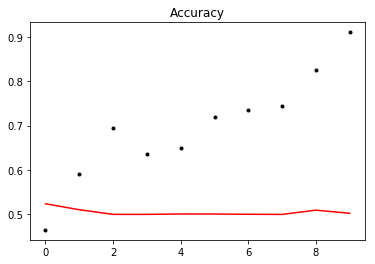

In [20]:
plt.figure()
plt.plot(epochs, train_acc, 'k.', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Accuracy')
plt.show()

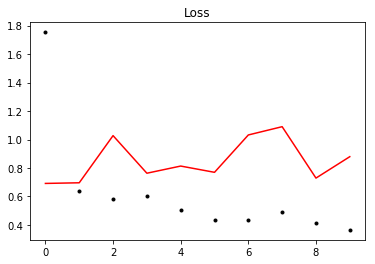

In [21]:
plt.figure()
plt.plot(epochs, train_loss, 'k.', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Loss')
plt.show()